# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [2]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

497351


## Master folder
folder storing all the libraries

In [3]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [4]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [5]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF2_4T1Primary')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/designed_probes_idt_oPool.xlsx


## Input files:

In [6]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary'

In [7]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [8]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [9]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [10]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 3.14 s, sys: 630 ms, total: 3.77 s
Wall time: 7.03 s


# Load gene-selection

In [11]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/marker_gene_mean_exp.csv


## Loading ends here

# Design targeting sequences

In [12]:
transcriptome[np.array([('ENSMUSG00000021831' in str(_g)) 
                        for _g in transcriptome['gene_id']])]

,transcript_id,sequence,FPKM,gene_id,gene_short_name
56744,ENSMUST00000022378.9,AGGCTACTTCAGCGGGCGCGCGGCCTGCGCCGGGGAGCCAAGCACG...,1,ENSMUSG00000021831.10,Ero1a
56745,ENSMUST00000227147.2,GCCTTTGGCTTCTGGGCGAGGAAAAAGTAAAGAGAACACATTTTAC...,1,ENSMUSG00000021831.10,Ero1a
56746,ENSMUST00000228564.2,ATGACATCAACCAGTGTGGAAGAAGAGACTGTGCCGTCAAACCCTG...,1,ENSMUSG00000021831.10,Ero1a
56747,ENSMUST00000228836.2,GTGGACCAAGCATGATGATTCGTCAGACAGCTTCTGCGAAATTGAC...,1,ENSMUSG00000021831.10,Ero1a
56748,ENSMUST00000227315.2,GATACCCCGACCCCGGAAGGACCGCGTCTTTGCGCCGGACGAGCTG...,1,ENSMUSG00000021831.10,Ero1a
56749,ENSMUST00000228777.2,GCTCTAGGGATCCCCTGGCCCTGTGTGTATCTTTCTTTCTTCTGAT...,1,ENSMUSG00000021831.10,Ero1a


In [13]:
transcriptome.loc[transcriptome['gene_short_name'] == 'Ero1l']

,transcript_id,sequence,FPKM,gene_id,gene_short_name


In [14]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a','Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))

In [15]:
gene_ids = target_gene_mean_exp_df.index.values

In [16]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

In [17]:
np.load(os.path.join(library_folder, 'replace_dict.npy'), allow_pickle=True).item()

{'Tcrg-C1': 'Trgc1',
 'Tcrg-C2': 'Trgc2',
 'Tcrg-C4': 'Trgc4',
 'Sept1': 'Septin1',
 'H2afy': 'Macroh2a2',
 'Qk': 'Qki',
 'Hist1h1b': 'H1f5',
 'Fam129b': 'Niban2',
 'Sept3': 'Septin3',
 'Hist1h2ab': 'H2ac4',
 'Il1f9': 'Il36g',
 'Cd163l1': 'Scart1',
 'Hist1h2af': 'H2ac10',
 'Fam71f2': 'Garin1a',
 'Hist1h3c': 'H3c3',
 'Ero1l': 'Ero1a',
 'Fam129c': 'Niban3',
 'Gm14548': 'Pira12',
 'Ptprg': 'PTPRG'}

In [18]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 4843 transcripts for 1030 target genes.
Gene	Transcript	N_probes
Trdv4
	ENSMUST00000103679.3	415
Trgv2
	ENSMUST00000103563.3	462
Trbc1
	ENSMUST00000192856.6	708
	ENSMUST00000103291.2	483
Trbc2
	ENSMUST00000103299.3	663
Trdc
	ENSMUST00000196323.2	3836
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Trgc1
	ENSMUST00000103558.3	895
Trgc2
	ENSMUST00000103561.3	885
Igkc
	ENSMUST00000103410.3	503
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Ighm
	ENSMUST00000177715.8	1669
	ENSMUST00000103426.3	1464
Iglc1
	ENSMUST00000200568.2	425
Iglc3
	ENSMUST00000200235.2	423
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Gramd3
	ENSMUST00000237355.2	2600
	ENSMUST00000237422.2	2324
	ENSMUST00000235794.2	1555
	ENSMUST00000237716.2	3717
	ENSMUST00000070166.6	2576
Aldh7a1
	ENSMUST00000172902.2	559
	ENSMUST00000174518.8	4102
	ENSMUST00000172734.8	1851
	ENSMUST00000066208.13	1885
	ENSMUST00000174704.8	1760
	ENSMUST00000168517.2	526
	ENSMUST00000170309.8	454
	ENSMUST0000017

# First round design

To determine number of probes

### Calculate and filter by probe GC

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][column_key_write] = pd.Series(gcs, index=probe_dict[gk][tk].index)


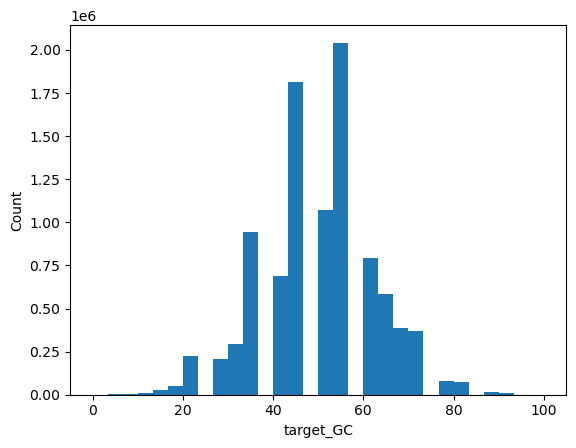

In [19]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trdv4
	ENSMUST00000103679.3: 224 / 415 probes passed the filter 40 < target_GC <  70.
Trgv2
	ENSMUST00000103563.3: 263 / 462 probes passed the filter 40 < target_GC <  70.
Trbc1
	ENSMUST00000192856.6: 513 / 708 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103291.2: 454 / 483 probes passed the filter 40 < target_GC <  70.
Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trdc
	ENSMUST00000196323.2: 2699 / 3836 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Trgc1
	ENSMUST00000103558.3: 530 / 895 probes passed the filter 40 < target_GC <  70.
Trgc2
	ENSMUST00000103561.3: 522 / 885 probes passed the filter 40 < target_GC <  70.
Igkc
	ENSMUST00000103410.3: 414 / 503 probes passed the filter 40 < target_GC <  70.
Ighd
	ENSMUST00000194162.6: 1282 / 1777 probes passed the filter 40

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000131670.3: 1182 / 1696 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000140924.3: 147 / 344 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000149414.2: 284 / 334 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000152688.2: 201 / 370 probes passed the filter 40 < target_GC <  70.
Msh2
	ENSMUST00000024967.14: 2144 / 3254 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000174240.2: 994 / 1723 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173097.8: 1437 / 2473 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172855.2: 313 / 601 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172596.2: 189 / 380 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000174703.2: 265 / 481 probes passed the filter 40 < target_GC <  70.
Camk4
	ENSMUST00000234205.2: 1351 / 1839 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000234654.2: 1377 / 1800 probes passed the filter 40 < target_GC <  70.
	ENSMUST000002340

	ENSMUST00000206793.2: 965 / 1186 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032997.8: 991 / 1206 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205426.2: 537 / 605 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205398.2: 1732 / 2024 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205642.2: 374 / 530 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000206731.2: 295 / 372 probes passed the filter 40 < target_GC <  70.
Mtor
	ENSMUST00000123566.8: 1510 / 2200 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103221.10: 7467 / 8535 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000057580.8: 735 / 974 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000129715.2: 470 / 569 probes passed the filter 40 < target_GC <  70.
Fam124a
	ENSMUST00000162987.8: 1229 / 1642 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000161899.8: 209 / 348 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000039

	ENSMUST00000172952.3: 1123 / 1843 probes passed the filter 40 < target_GC <  70.
H2-Ab1
	ENSMUST00000237429.2: 533 / 656 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000040828.7: 974 / 1183 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237342.2: 483 / 610 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237866.2: 762 / 860 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000235980.2: 477 / 743 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000236643.2: 932 / 1140 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173103.2: 495 / 599 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000174875.2: 384 / 486 probes passed the filter 40 < target_GC <  70.
Smim5
	ENSMUST00000152171.8: 927 / 1084 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000142089.2: 595 / 656 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000131566.2: 621 / 671 probes passed the filter 40 < target_GC <  70.
Npl
	ENSMUST0000004187

	ENSMUST00000208564.2: 554 / 649 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000207459.2: 633 / 684 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208129.2: 738 / 795 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208936.2: 223 / 264 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000207759.2: 145 / 167 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208204.2: 629 / 697 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208995.2: 692 / 890 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000207769.2: 437 / 763 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208392.2: 309 / 374 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208863.2: 285 / 390 probes passed the filter 40 < target_GC <  70.
Psmd3
	ENSMUST00000017365.15: 1633 / 2119 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000149489.8: 2250 / 2865 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000152102.2: 2387 /

	ENSMUST00000171470.8: 1816 / 4439 probes passed the filter 40 < target_GC <  70.
Cyp2c29
	ENSMUST00000176624.8: 1016 / 1730 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000003137.15: 1039 / 1754 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000177087.2: 1305 / 2793 probes passed the filter 40 < target_GC <  70.
Cyp2c39
	ENSMUST00000025968.5: 945 / 1788 probes passed the filter 40 < target_GC <  70.
Tnfsf8
	ENSMUST00000030047.3: 2040 / 3778 probes passed the filter 40 < target_GC <  70.
Itih3
	ENSMUST00000006697.17: 2689 / 2963 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227181.2: 2953 / 3273 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000227995.2: 1843 / 2071 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000226547.2: 609 / 643 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000226179.2: 396 / 452 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000228114.2: 0 / 0 probes passed the filter 40 < target_GC <  

	ENSMUST00000163020.2: 1479 / 2963 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000162621.2: 145 / 283 probes passed the filter 40 < target_GC <  70.
Ahnak
	ENSMUST00000092956.4: 13660 / 18071 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237912.2: 875 / 1159 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000092955.11: 568 / 801 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000236390.2: 1734 / 2171 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237033.2: 799 / 960 probes passed the filter 40 < target_GC <  70.
Mfsd7a
	ENSMUST00000031455.5: 2381 / 2688 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000238510.2: 1887 / 2082 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000238429.2: 589 / 691 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000238630.2: 3916 / 4562 probes passed the filter 40 < target_GC <  70.
Slc7a11
	ENSMUST00000194462.6: 1701 / 2390 probes passed the filter 40 < target_GC <  70.
	

	ENSMUST00000107049.2: 1900 / 2554 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000140283.2: 693 / 819 probes passed the filter 40 < target_GC <  70.
Ms4a6c
	ENSMUST00000165310.3: 971 / 1812 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000187462.2: 420 / 610 probes passed the filter 40 < target_GC <  70.
Ms4a6d
	ENSMUST00000025582.11: 836 / 1389 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000155669.8: 303 / 570 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000125291.3: 390 / 650 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135351.2: 326 / 431 probes passed the filter 40 < target_GC <  70.
Ms4a2
	ENSMUST00000186978.7: 758 / 2362 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000025583.12: 381 / 1182 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000164792.8: 423 / 981 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000189641.2: 295 / 618 probes passed the filter 40 < target_GC <  70.
	ENSMUST0000

	ENSMUST00000001927.12: 4858 / 6642 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000234008.2: 312 / 794 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000146839.2: 400 / 490 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135447.8: 2605 / 3085 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000112516.8: 3955 / 5111 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000112514.2: 3768 / 4841 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000127458.2: 1363 / 1876 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000234327.2: 200 / 217 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135750.2: 2058 / 3248 probes passed the filter 40 < target_GC <  70.
Ces1b
	ENSMUST00000109582.3: 1667 / 1935 probes passed the filter 40 < target_GC <  70.
Klrk1
	ENSMUST00000168919.8: 1610 / 3168 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032252.8: 700 / 1241 probes passed the filter 40 < target_GC <  70.
	ENSMUST00

	ENSMUST00000098660.10: 7001 / 8767 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000034829.6: 4083 / 4787 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000126347.2: 3230 / 4483 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000140824.2: 391 / 633 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000146099.2: 610 / 729 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000171654.8: 6731 / 8493 probes passed the filter 40 < target_GC <  70.
Sash1
	ENSMUST00000015449.6: 4887 / 7154 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000212869.2: 813 / 1045 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000212553.2: 672 / 811 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000213032.2: 536 / 1049 probes passed the filter 40 < target_GC <  70.
Acsl5
	ENSMUST00000225551.2: 367 / 491 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000224337.2: 383 / 500 probes passed the filter 40 < target_GC <  70.
	ENSMUST0000004

	ENSMUST00000047286.7: 2673 / 3179 probes passed the filter 40 < target_GC <  70.
Vtn
	ENSMUST00000128479.2: 1085 / 1142 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000017488.5: 1588 / 1715 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000146997.2: 826 / 877 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000153628.2: 581 / 649 probes passed the filter 40 < target_GC <  70.
Mbl1
	ENSMUST00000225792.2: 1221 / 1534 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000047095.4: 717 / 856 probes passed the filter 40 < target_GC <  70.
Nme6
	ENSMUST00000200005.5: 669 / 690 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000035053.12: 1001 / 1045 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000199203.5: 348 / 402 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000196797.5: 702 / 733 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000200345.5: 478 / 498 probes passed the filter 40 < target_GC <  70.
	ENSMUST0000020

	ENSMUST00000021050.14: 1462 / 1756 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000134118.2: 411 / 572 probes passed the filter 40 < target_GC <  70.
Tcf7
	ENSMUST00000086844.10: 1798 / 2442 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000109071.3: 1453 / 2030 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000238914.2: 676 / 784 probes passed the filter 40 < target_GC <  70.
Rpl7l1
	ENSMUST00000078286.6: 1984 / 2577 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000233192.2: 948 / 1281 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000233349.2: 337 / 429 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000233919.2: 461 / 628 probes passed the filter 40 < target_GC <  70.
Cd80
	ENSMUST00000231716.2: 1884 / 3144 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000099816.3: 1062 / 1672 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000232409.2: 518 / 719 probes passed the filter 40 < target_GC <  70.
Usp43
	E

	ENSMUST00000105797.9: 2754 / 3478 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000138493.8: 2345 / 3014 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000039204.10: 3466 / 4464 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000154979.2: 310 / 444 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000147426.2: 655 / 775 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000140403.2: 684 / 842 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000125045.2: 430 / 487 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000143614.8: 475 / 677 probes passed the filter 40 < target_GC <  70.
Pdgfb
	ENSMUST00000000500.8: 2001 / 2915 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229912.2: 554 / 623 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229795.2: 330 / 355 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000229168.2: 1364 / 2134 probes passed the filter 40 < target_GC <  70.
Cr2
	ENSMUST00000195120

	ENSMUST00000106162.8: 3016 / 3452 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000153968.2: 569 / 667 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000140426.2: 838 / 892 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000030673.7: 2787 / 3131 probes passed the filter 40 < target_GC <  70.
Cebpe
	ENSMUST00000064290.8: 887 / 1212 probes passed the filter 40 < target_GC <  70.
Agxt
	ENSMUST00000027491.7: 1327 / 1524 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191039.2: 356 / 373 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000190603.2: 823 / 906 probes passed the filter 40 < target_GC <  70.
Foxf1
	ENSMUST00000181504.2: 1348 / 2386 probes passed the filter 40 < target_GC <  70.
Gm5150
	ENSMUST00000194367.6: 696 / 1183 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000108347.3: 636 / 884 probes passed the filter 40 < target_GC <  70.
Src
	ENSMUST00000109533.8: 3169 / 3784 probes passed the filter 40 < target_GC <  70.


	ENSMUST00000029771.13: 935 / 1843 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000196746.2: 405 / 671 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000197731.2: 621 / 861 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000199997.2: 540 / 1101 probes passed the filter 40 < target_GC <  70.
Aif1
	ENSMUST00000173281.8: 316 / 433 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172693.8: 645 / 813 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173324.8: 701 / 846 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000025257.12: 674 / 818 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000172679.2: 589 / 734 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000173106.2: 364 / 448 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000174044.2: 704 / 746 probes passed the filter 40 < target_GC <  70.
Htra1
	ENSMUST00000150717.8: 922 / 1543 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000006367.8: 1

	ENSMUST00000208146.2: 1742 / 2404 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000208050.2: 332 / 333 probes passed the filter 40 < target_GC <  70.
Slc22a14
	ENSMUST00000093775.12: 1834 / 2184 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000170400.9: 1762 / 2081 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000152061.2: 456 / 560 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000127794.2: 253 / 311 probes passed the filter 40 < target_GC <  70.
Ccl24
	ENSMUST00000004936.10: 1019 / 1266 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000201401.2: 475 / 532 probes passed the filter 40 < target_GC <  70.
Fxyd3
	ENSMUST00000167369.8: 2472 / 2865 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000169313.8: 353 / 440 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000165465.8: 261 / 341 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000165862.5: 416 / 491 probes passed the filter 40 < target_GC <  70.
	ENSMUS

	ENSMUST00000148689.2: 491 / 572 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000102478.4: 1507 / 1671 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000128032.2: 685 / 759 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000124090.2: 313 / 349 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000156039.2: 636 / 677 probes passed the filter 40 < target_GC <  70.
Jag1
	ENSMUST00000028735.8: 3757 / 5583 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000133640.2: 1066 / 1434 probes passed the filter 40 < target_GC <  70.
Azgp1
	ENSMUST00000197571.2: 929 / 1175 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000035390.7: 1014 / 1268 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000199145.2: 516 / 579 probes passed the filter 40 < target_GC <  70.
Tasp1
	ENSMUST00000110079.9: 1398 / 2229 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000046656.9: 1453 / 2451 probes passed the filter 40 < target_GC <  70.
	ENSMUST00

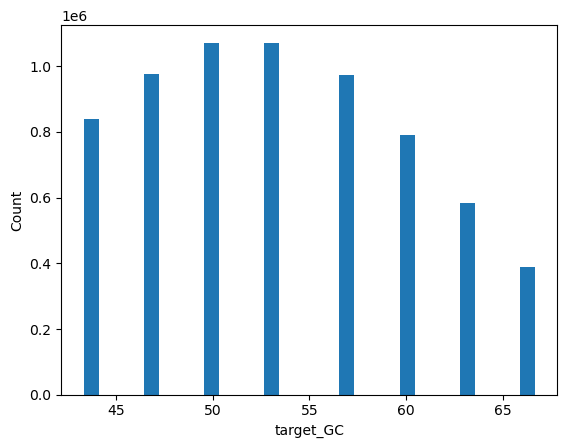

In [20]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:55: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][column_key_write] = pd.Series(tms, index=probe_dict[gk][tk].index)


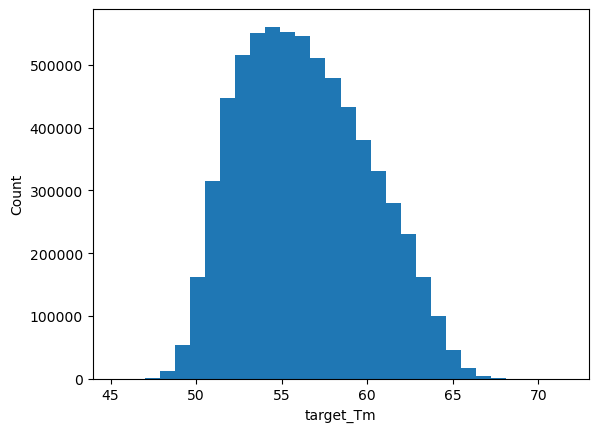

In [21]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trdv4
	ENSMUST00000103679.3: 214 / 224 probes passed the filter 50 < target_Tm <  65.
Trgv2
	ENSMUST00000103563.3: 256 / 263 probes passed the filter 50 < target_Tm <  65.
Trbc1
	ENSMUST00000192856.6: 504 / 513 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103291.2: 453 / 454 probes passed the filter 50 < target_Tm <  65.
Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trdc
	ENSMUST00000196323.2: 2548 / 2699 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Trgc1
	ENSMUST00000103558.3: 503 / 530 probes passed the filter 50 < target_Tm <  65.
Trgc2
	ENSMUST00000103561.3: 501 / 522 probes passed the filter 50 < target_Tm <  65.
Igkc
	ENSMUST00000103410.3: 396 / 414 probes passed the filter 50 < target_Tm <  65.
Ighd
	ENSMUST00000194162.6: 1230 / 1282 probes passed the filter 50

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000140986.3: 747 / 756 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000143351.2: 567 / 581 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000127126.2: 407 / 412 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138998.2: 599 / 604 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000128745.2: 310 / 310 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000134209.2: 366 / 369 probes passed the filter 50 < target_Tm <  65.
Hhip
	ENSMUST00000155850.3: 638 / 650 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000079038.4: 3878 / 4047 probes passed the filter 50 < target_Tm <  65.
Cd200r3
	ENSMUST00000114613.9: 595 / 622 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000114612.8: 446 / 468 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000077178.13: 458 / 486 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000048479.14: 607 / 640 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000114611.10:

	ENSMUST00000199412.5: 2473 / 2549 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000196014.5: 1773 / 1837 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000196800.2: 1912 / 1979 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000048957.11: 6091 / 6233 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000200581.2: 1786 / 1817 probes passed the filter 50 < target_Tm <  65.
Axl
	ENSMUST00000002677.11: 3189 / 3298 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000085948.11: 2927 / 3024 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000124442.8: 532 / 533 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000137211.2: 699 / 708 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000132989.8: 2115 / 2189 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000132038.3: 488 / 495 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000147680.2: 320 / 325 probes passed the filter 50 < target_Tm <  65.
	ENSMUST000001373

	ENSMUST00000075552.7: 1308 / 1340 probes passed the filter 50 < target_Tm <  65.
Klk1b27
	ENSMUST00000079859.7: 690 / 698 probes passed the filter 50 < target_Tm <  65.
Cdh4
	ENSMUST00000000314.13: 5183 / 5252 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108911.2: 976 / 990 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000124708.2: 384 / 394 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000136411.2: 338 / 338 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000129659.2: 630 / 637 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000098996.2: 40 / 40 probes passed the filter 50 < target_Tm <  65.
Pde5a
	ENSMUST00000066728.10: 3839 / 3951 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000200389.2: 4051 / 4165 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000198314.2: 1428 / 1463 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199253.2: 298 / 298 probes passed the filter 50 < target_Tm <  65.
Irs1
	ENSMU

	ENSMUST00000024044.7: 2634 / 2708 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145977.8: 227 / 235 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145818.2: 511 / 524 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000151594.8: 1462 / 1501 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000130378.2: 574 / 603 probes passed the filter 50 < target_Tm <  65.
Hpx
	ENSMUST00000033185.10: 1365 / 1375 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000210531.2: 529 / 530 probes passed the filter 50 < target_Tm <  65.
Fbxl7
	ENSMUST00000059204.11: 2993 / 3058 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000226377.2: 1004 / 1030 probes passed the filter 50 < target_Tm <  65.
Lag3
	ENSMUST00000032217.2: 1460 / 1531 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000139571.2: 362 / 365 probes passed the filter 50 < target_Tm <  65.
Myof
	ENSMUST00000224560.2: 475 / 484 probes passed the filter 50 < target_Tm <  65.
	ENSMU

	ENSMUST00000182617.2: 936 / 952 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215397.2: 261 / 270 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000183182.2: 608 / 642 probes passed the filter 50 < target_Tm <  65.
Dcn
	ENSMUST00000105287.11: 1054 / 1078 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000163448.4: 1001 / 1028 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000218853.2: 350 / 368 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000219784.2: 125 / 133 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000219539.2: 1573 / 1628 probes passed the filter 50 < target_Tm <  65.
Gpr68
	ENSMUST00000110066.8: 2553 / 2613 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000110065.8: 2314 / 2374 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000135684.2: 318 / 329 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000124459.2: 378 / 382 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000128306

	ENSMUST00000228821.2: 240 / 259 probes passed the filter 50 < target_Tm <  65.
Cd226
	ENSMUST00000235651.2: 1057 / 1102 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000236644.2: 332 / 340 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000236828.2: 1404 / 1473 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237110.2: 278 / 291 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000097496.4: 623 / 650 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237979.2: 731 / 754 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000236450.2: 403 / 416 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000236452.2: 417 / 438 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000236835.2: 272 / 278 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000037142.13: 1062 / 1105 probes passed the filter 50 < target_Tm <  65.
Gpr39
	ENSMUST00000027581.7: 2251 / 2277 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159359

	ENSMUST00000146882.2: 488 / 494 probes passed the filter 50 < target_Tm <  65.
Stab1
	ENSMUST00000160024.8: 336 / 344 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159480.8: 1042 / 1063 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000162169.8: 2059 / 2084 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000036618.14: 7089 / 7209 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159208.8: 177 / 181 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161129.8: 2608 / 2636 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000160720.2: 2989 / 3022 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161631.2: 750 / 761 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159249.2: 468 / 474 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000162763.2: 399 / 400 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161464.2: 361 / 363 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159757.8: 

	ENSMUST00000128260.9: 1066 / 1078 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000122006.8: 728 / 733 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000149585.8: 792 / 795 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000151830.2: 243 / 248 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138229.2: 660 / 667 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000107282.4: 386 / 389 probes passed the filter 50 < target_Tm <  65.
Syne1
	ENSMUST00000215295.2: 22079 / 22600 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000095899.5: 2791 / 2818 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000217064.2: 1914 / 1947 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215467.2: 3297 / 3378 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215021.2: 1407 / 1486 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000217592.2: 1750 / 1805 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0000004163

	ENSMUST00000111950.4: 2069 / 2107 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203016.2: 1193 / 1222 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203773.2: 459 / 461 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000126836.4: 320 / 327 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203235.2: 236 / 242 probes passed the filter 50 < target_Tm <  65.
Adgrg5
	ENSMUST00000153448.9: 348 / 349 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000166802.9: 1664 / 1702 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000074570.10: 2456 / 2510 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000128308.3: 2550 / 2604 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000142991.2: 292 / 307 probes passed the filter 50 < target_Tm <  65.
Dusp16
	ENSMUST00000129433.4: 2454 / 2510 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000100857.10: 3320 / 3400 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00

	ENSMUST00000225762.2: 618 / 629 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000225498.2: 407 / 417 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000226023.2: 408 / 414 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000224054.2: 386 / 393 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000225856.2: 381 / 388 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000225966.2: 301 / 306 probes passed the filter 50 < target_Tm <  65.
Cd3g
	ENSMUST00000002101.12: 694 / 721 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159019.3: 1130 / 1174 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000160886.2: 255 / 270 probes passed the filter 50 < target_Tm <  65.
Ptpn22
	ENSMUST00000146071.8: 1710 / 1755 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000029433.9: 1731 / 1772 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000198530.2: 452 / 463 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000197997.2

	ENSMUST00000162536.8: 4083 / 4185 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159141.8: 325 / 330 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159818.2: 312 / 325 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000026921.13: 3384 / 3449 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000162665.8: 3395 / 3466 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000162602.8: 2529 / 2593 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000160581.8: 2490 / 2553 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161355.8: 2510 / 2578 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000162531.8: 2759 / 2824 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000160766.8: 4032 / 4131 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159537.8: 2343 / 2395 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161277.8: 2289 / 2340 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000238870

	ENSMUST00000089398.9: 3567 / 3636 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000163494.3: 1699 / 1729 probes passed the filter 50 < target_Tm <  65.
Ror1
	ENSMUST00000039630.6: 3407 / 3457 probes passed the filter 50 < target_Tm <  65.
Gzmb
	ENSMUST00000015581.6: 977 / 993 probes passed the filter 50 < target_Tm <  65.
Col6a3
	ENSMUST00000097653.11: 7625 / 7805 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000150769.2: 439 / 455 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000136916.8: 2903 / 2960 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145750.2: 504 / 526 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000130846.9: 4525 / 4642 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000187753.2: 348 / 369 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000188587.7: 7182 / 7355 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000056925.16: 8555 / 8777 probes passed the filter 50 < target_Tm <  65.
Hoxc1

	ENSMUST00000189862.7: 2585 / 2658 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000189361.2: 4570 / 4662 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000186553.2: 1007 / 1030 probes passed the filter 50 < target_Tm <  65.
Ccrl2
	ENSMUST00000111888.3: 1813 / 1843 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199839.5: 1361 / 1368 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000195968.2: 421 / 422 probes passed the filter 50 < target_Tm <  65.
Ldb2
	ENSMUST00000199534.5: 1493 / 1532 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000070748.10: 1371 / 1410 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199256.5: 1529 / 1570 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199261.2: 1328 / 1367 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000199471.5: 439 / 453 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000198356.2: 504 / 508 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00

	ENSMUST00000107612.3: 520 / 536 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000154511.2: 580 / 581 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000136308.2: 465 / 471 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000134915.2: 294 / 307 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000131231.2: 221 / 228 probes passed the filter 50 < target_Tm <  65.
Lad1
	ENSMUST00000038760.10: 2268 / 2310 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000190773.7: 839 / 850 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000185756.2: 706 / 714 probes passed the filter 50 < target_Tm <  65.
Mms22l
	ENSMUST00000173079.8: 1538 / 1606 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108222.9: 2471 / 2552 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138567.9: 583 / 602 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000139050.2: 185 / 194 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000050446.1

	ENSMUST00000006367.8: 1382 / 1406 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000153290.8: 1310 / 1334 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000140741.2: 166 / 168 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000150905.2: 485 / 490 probes passed the filter 50 < target_Tm <  65.
Tnf
	ENSMUST00000025263.15: 1329 / 1360 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000167924.2: 1215 / 1240 probes passed the filter 50 < target_Tm <  65.
Tspan18
	ENSMUST00000111265.9: 3006 / 3059 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000028646.4: 983 / 995 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000154951.8: 2572 / 2662 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000181716.8: 714 / 726 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000152141.2: 432 / 451 probes passed the filter 50 < target_Tm <  65.
Nxph1
	ENSMUST00000162942.2: 1574 / 1587 probes passed the filter 50 < target_Tm <  65.
	ENSMUS

	ENSMUST00000067680.11: 5270 / 5396 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138363.2: 2636 / 2700 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000134504.8: 535 / 551 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000127524.2: 536 / 550 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000206313.2: 551 / 580 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000206426.2: 895 / 922 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000154144.2: 231 / 237 probes passed the filter 50 < target_Tm <  65.
Ifi205
	ENSMUST00000059226.7: 617 / 642 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192166.2: 1007 / 1061 probes passed the filter 50 < target_Tm <  65.
Lsr
	ENSMUST00000098553.11: 1450 / 1470 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000001279.15: 1672 / 1699 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108116.10: 1597 / 1617 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000

	ENSMUST00000108786.8: 533 / 535 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108787.9: 516 / 519 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000045697.12: 639 / 644 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108785.2: 544 / 548 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000108784.4: 515 / 521 probes passed the filter 50 < target_Tm <  65.
Ephb4
	ENSMUST00000061244.15: 3262 / 3330 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000144296.8: 2894 / 2965 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000111055.9: 3248 / 3316 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000166239.8: 2990 / 3056 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000111054.2: 2975 / 3039 probes passed the filter 50 < target_Tm <  65.
Phlda2
	ENSMUST00000010904.5: 486 / 497 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000207425.2: 290 / 299 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0000020

	ENSMUST00000131907.10: 1722 / 1778 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000185281.8: 724 / 770 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000182788.2: 403 / 417 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000182701.3: 559 / 600 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000187663.2: 215 / 226 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000241237.1: 701 / 715 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000241626.1: 463 / 469 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242216.1: 1507 / 1538 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242301.1: 264 / 289 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242329.1: 649 / 684 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242421.1: 349 / 365 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242455.1: 517 / 557 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000242541.1: 680 / 695 pr

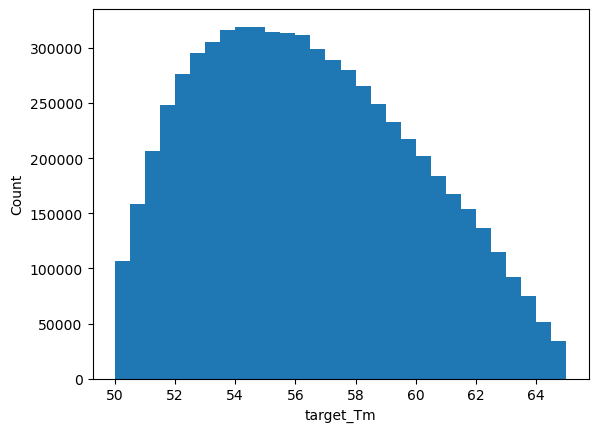

In [22]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [23]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [24]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Mreg.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ddx49.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Kdf1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Xcr1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Prdm1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Rras2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Clec4a1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ror1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cd22.
Construct a OTTable using 16/16 transcripts with FPKM > 0.
Generate OTTable for gene Pdgfc.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Myof.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate O

Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ppfia4.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Slc7a5.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Il36g.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Lox.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Col5a1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Il12rb2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Sh2d1a.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Slc7a2.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Scn3a.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Alox15.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Epha2.
Cons

Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Cxcr6.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Lamb3.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Fabp1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cd19.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Adgrg5.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Hhip.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Trgc1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cdh5.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Dlat.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Atm.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Hlf.
Construct a OTTab

Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Bok.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Araf.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Klre1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Samd3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene St8sia1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Htr1b.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ltbp4.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Lrg1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ltbp1.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Psmd3.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Tnc.
Construct 

Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Gata5.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Chst3.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Tmem252.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Prok2.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Nme6.
Construct a OTTable using 15/15 transcripts with FPKM > 0.
Generate OTTable for gene Apoe.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene Ccbe1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Gja4.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ralgps2.
Construct a OTTable using 15/15 transcripts with FPKM > 0.
Generate OTTable for gene Flt4.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Scart1.
Con

Construct a OTTable using 13/13 transcripts with FPKM > 0.
Generate OTTable for gene Anxa1.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Btbd11.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Tnfrsf13b.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Ikzf4.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Bcl2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Gm21762.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Il3ra.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Npr3.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Cma1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Klrg1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Plk1.
Con

Construct a OTTable using 14/14 transcripts with FPKM > 0.
Generate OTTable for gene Tbx3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Irx2.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Lrp1.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene F7.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Rrm2.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Pdgfb.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Tmem100.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Hc.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Lrp5.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ccr8.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Pdha1.
Construct a OTTa

Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Clec14a.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ankrd1.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Cd247.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Sult1d1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Cps1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cd177.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Cdh11.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ier3.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Aldh7a1.
Construct a OTTable using 9/9 transcripts with FPKM > 0.
Generate OTTable for gene Fpr2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Xcl1.
Constru

Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ggt1.
Construct a OTTable using 20/20 transcripts with FPKM > 0.
Generate OTTable for gene Cd8b1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Tifab.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Il1rn.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Tbxas1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene F13a1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a6c.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Arg1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Sfrp2.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Procr.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Fcer1a.
Constru

Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Abca13.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ibsp.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ndrg3.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene Znrf3.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ccnb1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Akap12.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Fstl1.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Vegfc.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Fbln1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Spry2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ptger3.
Constr

Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene Ddx28.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Trpm6.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Gata6.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Cenpw.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Acss1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Ltc4s.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Dnase2b.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Coro2b.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Smg9.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Npl.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Rab25.
Construc

In [25]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 146157/146157 transcripts with FPKM > 0.
Processed 10000/146157 sequences.
Processed 20000/146157 sequences.
Processed 30000/146157 sequences.
Processed 40000/146157 sequences.
Processed 50000/146157 sequences.
Processed 60000/146157 sequences.
Processed 70000/146157 sequences.
Processed 80000/146157 sequences.
Processed 90000/146157 sequences.
Processed 100000/146157 sequences.
Processed 110000/146157 sequences.
Processed 120000/146157 sequences.
Processed 130000/146157 sequences.
Processed 140000/146157 sequences.


In [26]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/1030 genes.
Calculate OTs for 1/1030 genes.
Calculate OTs for 2/1030 genes.
Calculate OTs for 3/1030 genes.
Calculate OTs for 4/1030 genes.
Calculate OTs for 5/1030 genes.
Calculate OTs for 6/1030 genes.
Calculate OTs for 7/1030 genes.
Calculate OTs for 8/1030 genes.
Calculate OTs for 9/1030 genes.
Calculate OTs for 10/1030 genes.
Calculate OTs for 11/1030 genes.
Calculate OTs for 12/1030 genes.
Calculate OTs for 13/1030 genes.
Calculate OTs for 14/1030 genes.
Calculate OTs for 15/1030 genes.
Calculate OTs for 16/1030 genes.
Calculate OTs for 17/1030 genes.
Calculate OTs for 18/1030 genes.
Calculate OTs for 19/1030 genes.
Calculate OTs for 20/1030 genes.
Calculate OTs for 21/1030 genes.
Calculate OTs for 22/1030 genes.
Calculate OTs for 23/1030 genes.
Calculate OTs for 24/1030 genes.
Calculate OTs for 25/1030 genes.
Calculate OTs for 26/1030 genes.
Calculate OTs for 27/1030 genes.
Calculate OTs for 28/1030 genes.
Calculate OTs for 29/1030 genes.
Calculate OTs for 30

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/OTTable_dict.py:171: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[ot_key] = pd.Series(ot_counts, index=df.index)


Calculate OTs for 251/1030 genes.
Calculate OTs for 252/1030 genes.
Calculate OTs for 253/1030 genes.
Calculate OTs for 254/1030 genes.
Calculate OTs for 255/1030 genes.
Calculate OTs for 256/1030 genes.
Calculate OTs for 257/1030 genes.
Calculate OTs for 258/1030 genes.
Calculate OTs for 259/1030 genes.
Calculate OTs for 260/1030 genes.
Calculate OTs for 261/1030 genes.
Calculate OTs for 262/1030 genes.
Calculate OTs for 263/1030 genes.
Calculate OTs for 264/1030 genes.
Calculate OTs for 265/1030 genes.
Calculate OTs for 266/1030 genes.
Calculate OTs for 267/1030 genes.
Calculate OTs for 268/1030 genes.
Calculate OTs for 269/1030 genes.
Calculate OTs for 270/1030 genes.
Calculate OTs for 271/1030 genes.
Calculate OTs for 272/1030 genes.
Calculate OTs for 273/1030 genes.
Calculate OTs for 274/1030 genes.
Calculate OTs for 275/1030 genes.
Calculate OTs for 276/1030 genes.
Calculate OTs for 277/1030 genes.
Calculate OTs for 278/1030 genes.
Calculate OTs for 279/1030 genes.
Calculate OTs 

Calculate OTs for 500/1030 genes.
Calculate OTs for 501/1030 genes.
Calculate OTs for 502/1030 genes.
Calculate OTs for 503/1030 genes.
Calculate OTs for 504/1030 genes.
Calculate OTs for 505/1030 genes.
Calculate OTs for 506/1030 genes.
Calculate OTs for 507/1030 genes.
Calculate OTs for 508/1030 genes.
Calculate OTs for 509/1030 genes.
Calculate OTs for 510/1030 genes.
Calculate OTs for 511/1030 genes.
Calculate OTs for 512/1030 genes.
Calculate OTs for 513/1030 genes.
Calculate OTs for 514/1030 genes.
Calculate OTs for 515/1030 genes.
Calculate OTs for 516/1030 genes.
Calculate OTs for 517/1030 genes.
Calculate OTs for 518/1030 genes.
Calculate OTs for 519/1030 genes.
Calculate OTs for 520/1030 genes.
Calculate OTs for 521/1030 genes.
Calculate OTs for 522/1030 genes.
Calculate OTs for 523/1030 genes.
Calculate OTs for 524/1030 genes.
Calculate OTs for 525/1030 genes.
Calculate OTs for 526/1030 genes.
Calculate OTs for 527/1030 genes.
Calculate OTs for 528/1030 genes.
Calculate OTs 

Calculate OTs for 743/1030 genes.
Calculate OTs for 744/1030 genes.
Calculate OTs for 745/1030 genes.
Calculate OTs for 746/1030 genes.
Calculate OTs for 747/1030 genes.
Calculate OTs for 748/1030 genes.
Calculate OTs for 749/1030 genes.
Calculate OTs for 750/1030 genes.
Calculate OTs for 751/1030 genes.
Calculate OTs for 752/1030 genes.
Calculate OTs for 753/1030 genes.
Calculate OTs for 754/1030 genes.
Calculate OTs for 755/1030 genes.
Calculate OTs for 756/1030 genes.
Calculate OTs for 757/1030 genes.
Calculate OTs for 758/1030 genes.
Calculate OTs for 759/1030 genes.
Calculate OTs for 760/1030 genes.
Calculate OTs for 761/1030 genes.
Calculate OTs for 762/1030 genes.
Calculate OTs for 763/1030 genes.
Calculate OTs for 764/1030 genes.
Calculate OTs for 765/1030 genes.
Calculate OTs for 766/1030 genes.
Calculate OTs for 767/1030 genes.
Calculate OTs for 768/1030 genes.
Calculate OTs for 769/1030 genes.
Calculate OTs for 770/1030 genes.
Calculate OTs for 771/1030 genes.
Calculate OTs 

Calculate OTs for 990/1030 genes.
Calculate OTs for 991/1030 genes.
Calculate OTs for 992/1030 genes.
Calculate OTs for 993/1030 genes.
Calculate OTs for 994/1030 genes.
Calculate OTs for 995/1030 genes.
Calculate OTs for 996/1030 genes.
Calculate OTs for 997/1030 genes.
Calculate OTs for 998/1030 genes.
Calculate OTs for 999/1030 genes.
Calculate OTs for 1000/1030 genes.
Calculate OTs for 1001/1030 genes.
Calculate OTs for 1002/1030 genes.
Calculate OTs for 1003/1030 genes.
Calculate OTs for 1004/1030 genes.
Calculate OTs for 1005/1030 genes.
Calculate OTs for 1006/1030 genes.
Calculate OTs for 1007/1030 genes.
Calculate OTs for 1008/1030 genes.
Calculate OTs for 1009/1030 genes.
Calculate OTs for 1010/1030 genes.
Calculate OTs for 1011/1030 genes.
Calculate OTs for 1012/1030 genes.
Calculate OTs for 1013/1030 genes.
Calculate OTs for 1014/1030 genes.
Calculate OTs for 1015/1030 genes.
Calculate OTs for 1016/1030 genes.
Calculate OTs for 1017/1030 genes.
Calculate OTs for 1018/1030 ge

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000102596.8: 1840 / 1856 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000132030.2: 687 / 687 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000127943.2: 540 / 540 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000123640.2: 498 / 498 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139957.2: 417 / 417 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000134336.3: 317 / 333 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000167288.8: 1832 / 1848 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Nup85
	ENSMUST00000021085.11: 1704 / 1704 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135893.2: 375 / 375 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000144473.8: 717 / 717 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000140986.3: 747 / 747 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST

	ENSMUST00000154322.8: 3253 / 3253 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000124502.8: 3190 / 3190 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000131744.2: 3233 / 3233 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000124885.2: 520 / 520 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000123042.2: 328 / 328 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Il7r
	ENSMUST00000228782.2: 1336 / 1385 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000003981.6: 1347 / 1396 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000227234.2: 741 / 741 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000228673.2: 178 / 178 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Il17rb
	ENSMUST00000122205.9: 1610 / 1610 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135888.8: 1587 / 1587 probes passed the filter -inf < target_OT_rtRNA <  

	ENSMUST00000238147.2: 670 / 670 probes passed the filter -inf < target_OT_rtRNA <  0.5.
St6galnac3
	ENSMUST00000200397.5: 4942 / 4942 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000199707.2: 304 / 304 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000064460.7: 455 / 455 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000200576.2: 596 / 596 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000198775.2: 309 / 309 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ccbe1
	ENSMUST00000146610.2: 1973 / 1973 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000061103.14: 3130 / 3130 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130300.3: 3991 / 3991 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000235872.2: 1371 / 1371 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000236848.2: 470 / 470 probes passed the filter -inf < target_OT_rtRNA <

	ENSMUST00000131847.8: 684 / 684 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000134637.8: 1480 / 1480 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000136692.2: 624 / 624 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000151674.3: 536 / 536 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Spata7
	ENSMUST00000048402.12: 1108 / 1108 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000155899.2: 852 / 852 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000222195.2: 990 / 990 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000101144.10: 766 / 766 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130136.2: 490 / 490 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000101146.4: 1030 / 1030 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000221273.2: 1105 / 1105 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENS

	ENSMUST00000219509.2: 897 / 897 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000218441.2: 1919 / 1919 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000220330.2: 118 / 118 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000219051.2: 757 / 757 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000218669.2: 262 / 262 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000220263.2: 1424 / 1424 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000079751.9: 1646 / 1646 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000105484.10: 2169 / 2169 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Yap1
	ENSMUST00000086580.12: 2478 / 2478 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000065353.13: 2522 / 2522 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000174604.8: 924 / 924 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	

	ENSMUST00000115442.8: 2994 / 2994 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000145473.2: 2152 / 2152 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000152802.2: 397 / 397 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000148903.2: 288 / 288 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000080469.12: 2773 / 2773 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Asb2
	ENSMUST00000021617.14: 1991 / 1991 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000127447.2: 1776 / 1776 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000149431.2: 1706 / 1706 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135694.2: 310 / 310 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Izumo1r
	ENSMUST00000069408.10: 906 / 906 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000117620.8: 859 / 859 probes passed the filter -inf < target_OT_rtRNA <

	ENSMUST00000010286.8: 1613 / 1613 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000146033.8: 285 / 285 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139422.8: 439 / 439 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000137832.8: 473 / 473 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130708.2: 235 / 235 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000123378.2: 412 / 412 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000101103.4: 509 / 509 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ms4a3
	ENSMUST00000186023.7: 644 / 644 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000112984.4: 683 / 683 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000190642.2: 667 / 667 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Foxm1
	ENSMUST00000123988.8: 922 / 922 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUS

	ENSMUST00000125761.8: 2410 / 2410 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000154249.8: 4510 / 4510 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000049095.6: 3068 / 3068 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150668.8: 2402 / 2402 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000133225.2: 677 / 677 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000156126.2: 596 / 596 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000143724.8: 1609 / 1609 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150614.2: 226 / 226 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Itk
	ENSMUST00000020664.13: 3365 / 3365 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000101306.4: 839 / 839 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000155991.2: 682 / 682 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENS

	ENSMUST00000033050.5: 1855 / 1855 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000209319.2: 668 / 668 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Procr
	ENSMUST00000029140.12: 1158 / 1158 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000143493.2: 1246 / 1246 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000155095.2: 456 / 456 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000132608.2: 390 / 390 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Adgrf5
	ENSMUST00000226087.2: 3792 / 3792 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000224278.2: 546 / 546 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000225466.2: 370 / 370 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000225962.2: 3533 / 3533 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000225004.2: 634 / 634 probes passed the filter -inf < target_OT_rtRNA <  0.

	ENSMUST00000048608.16: 3602 / 3602 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000108815.8: 3706 / 3706 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000153112.2: 594 / 594 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000148252.2: 3075 / 3075 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000184751.8: 456 / 456 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000126842.2: 375 / 375 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000125233.2: 292 / 292 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130935.2: 729 / 729 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000144648.2: 528 / 528 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000130772.2: 1399 / 1399 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000147266.2: 423 / 423 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST0000

	ENSMUST00000169652.3: 2668 / 2668 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000225063.2: 2260 / 2260 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cxcl14
	ENSMUST00000224801.2: 951 / 951 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000021970.11: 1189 / 1189 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ero1a
	ENSMUST00000022378.9: 1929 / 1929 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000227147.2: 367 / 367 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000228564.2: 340 / 340 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000228836.2: 287 / 287 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000227315.2: 154 / 154 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000228777.2: 285 / 285 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Lect2
	ENSMUST00000062806.6: 513 / 513 probes passed the filter -inf < target_OT_rtRNA <

	ENSMUST00000147365.2: 138 / 138 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000051929.13: 725 / 725 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ppil1
	ENSMUST00000024802.10: 1078 / 1078 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000234880.2: 843 / 843 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000234315.2: 789 / 789 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000234139.2: 829 / 829 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135123.3: 1117 / 1117 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000136811.8: 620 / 620 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000129157.3: 372 / 372 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Upk1b
	ENSMUST00000057767.6: 1297 / 1297 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000232536.2: 319 / 319 probes passed the filter -inf < target_OT_rtRNA <  0.5.
D

	ENSMUST00000000500.8: 1974 / 1974 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000229912.2: 550 / 550 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000229795.2: 329 / 329 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000229168.2: 1346 / 1346 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cr2
	ENSMUST00000195120.6: 3040 / 3040 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000193356.2: 1453 / 1453 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000192604.6: 518 / 518 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000238929.2: 1895 / 1895 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000193436.2: 122 / 122 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000193801.2: 136 / 136 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000195737.2: 420 / 420 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUS

	ENSMUST00000012847.3: 849 / 849 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208960.2: 539 / 539 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000207979.2: 549 / 549 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000207906.2: 614 / 614 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Anxa8
	ENSMUST00000022519.15: 1504 / 1504 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000120077.2: 982 / 982 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Gpx3
	ENSMUST00000125094.9: 615 / 615 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000082430.11: 1210 / 1210 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000149324.3: 505 / 505 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Rhbdl2
	ENSMUST00000124290.2: 1201 / 1201 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150286.2: 280 / 280 probes passed the filter -inf < target_OT_rtRNA <  

	ENSMUST00000046322.14: 1134 / 1134 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000159149.8: 767 / 767 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000159171.2: 1021 / 1021 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000162136.2: 587 / 587 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000162887.2: 406 / 406 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000161050.2: 361 / 361 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Sf3a2
	ENSMUST00000148665.8: 1388 / 1388 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000151928.8: 624 / 624 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000147440.2: 288 / 288 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139461.2: 571 / 571 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cecr2
	ENSMUST00000148346.2: 1956 / 1956 probes passed the filter -inf < target_OT_rtRNA <  0.5.


	ENSMUST00000046091.7: 777 / 777 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Mmp12
	ENSMUST00000150167.2: 225 / 225 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000120655.8: 815 / 815 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000005950.12: 1587 / 1608 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000065079.6: 650 / 650 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000138220.2: 202 / 202 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000148005.8: 1925 / 1925 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000127722.2: 1008 / 1029 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Rnf43
	ENSMUST00000134684.8: 1929 / 1929 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000123658.9: 706 / 706 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000092800.12: 3376 / 3392 probes passed the filter -inf < target_OT_rtRNA <  0.

	ENSMUST00000135169.8: 610 / 610 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000105672.10: 1410 / 1449 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000030808.10: 1460 / 1499 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000105671.8: 1024 / 1044 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139826.8: 654 / 654 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000146133.8: 301 / 301 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000116257.8: 1476 / 1515 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000060901.11: 876 / 876 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000126707.3: 624 / 624 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ramp3
	ENSMUST00000045374.8: 1057 / 1057 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139540.2: 1121 / 1121 probes passed the filter -inf < target_OT_rtRNA <  0.5.


	ENSMUST00000062787.9: 1641 / 1641 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cd79b
	ENSMUST00000044228.11: 1325 / 1325 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000167143.2: 1104 / 1104 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ccnd1
	ENSMUST00000093962.5: 2411 / 2411 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208193.2: 1502 / 1502 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135985.2: 378 / 378 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Sult2b1
	ENSMUST00000075571.16: 754 / 754 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000209739.2: 1309 / 1309 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000210754.2: 998 / 998 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000210147.2: 431 / 431 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000209435.2: 328 / 328 probes passed the filter -inf < target_OT_r

	ENSMUST00000243738.1: 972 / 972 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000245032.1: 671 / 705 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000246014.1: 694 / 694 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000246080.1: 772 / 772 probes passed the filter -inf < target_OT_rtRNA <  0.5.
4930417O13Rik
	ENSMUST00000204911.3: 2065 / 2065 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000204597.2: 485 / 485 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000245199.1: 917 / 917 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000246494.1: 2049 / 2092 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000244698.1: 2095 / 2138 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000203841.3: 276 / 276 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000205000.2: 694 / 694 probes passed the filter -inf < target_OT_rtRNA <  0.5.
D

### Off-targets to transcriptome

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/OTTable_dict.py:271: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][speci_key] = pd.Series(specificities, index=probe_dict[gk][tk].index)
/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/OTTable_dict.py:272: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][isospeci_key] = pd.Series(isospecificities, index=probe_dict[gk][tk].index)


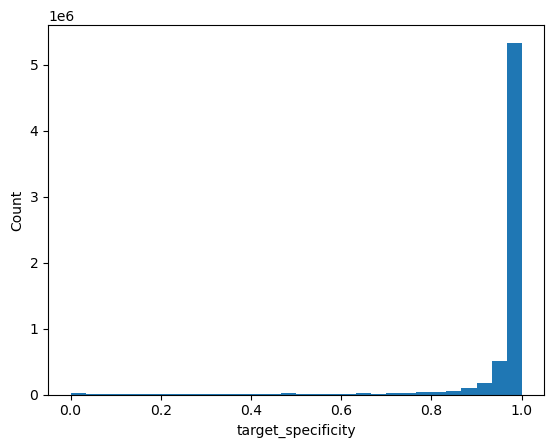

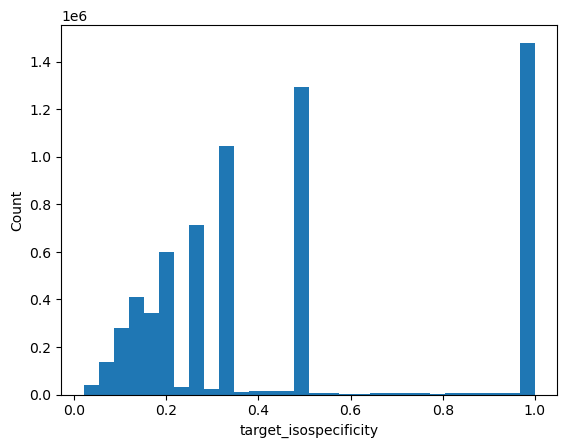

In [27]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [28]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

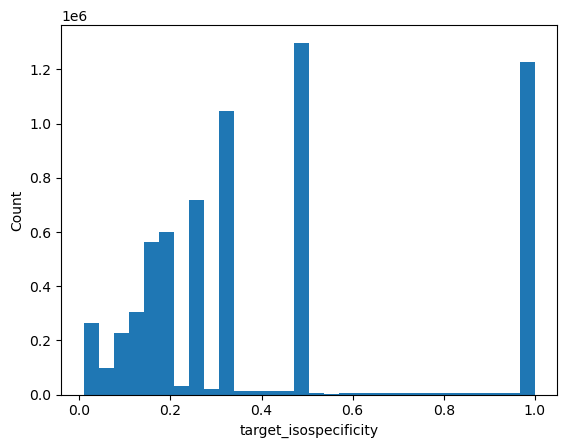

In [29]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trdv4
	ENSMUST00000103679.3: 158 / 214 probes passed the filter 0.99 < target_specificity <  inf.
Trgv2
	ENSMUST00000103563.3: 70 / 256 probes passed the filter 0.99 < target_specificity <  inf.
Trbc1
	ENSMUST00000192856.6: 148 / 504 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103291.2: 104 / 453 probes passed the filter 0.99 < target_specificity <  inf.
Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trdc
	ENSMUST00000196323.2: 2002 / 2486 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 507 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 234 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Trgc1
	ENSMUST00000103558.3: 36 / 503 probes passed the filter 0.99 < target_specificity <  inf.
Trgc2
	ENSMUST00000103561.3: 41 / 501 probes passed the filter 0.99 < target_specificity <  inf.
Igkc
	ENSMUST00000103410.3: 330 / 3

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000102596.8: 1336 / 1840 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000132030.2: 462 / 687 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000127943.2: 423 / 540 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123640.2: 379 / 498 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000139957.2: 324 / 417 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134336.3: 263 / 317 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000167288.8: 1348 / 1832 probes passed the filter 0.99 < target_specificity <  inf.
Nup85
	ENSMUST00000021085.11: 1323 / 1704 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000135893.2: 258 / 375 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000144473.8: 548 / 717 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000140986.3: 620 / 747 probes passed the filter 0.99 < ta

	ENSMUST00000123974.2: 685 / 885 probes passed the filter 0.99 < target_specificity <  inf.
Siglecg
	ENSMUST00000005592.7: 1250 / 2116 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000154322.8: 1861 / 3253 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124502.8: 1861 / 3190 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000131744.2: 1950 / 3233 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124885.2: 241 / 520 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123042.2: 10 / 328 probes passed the filter 0.99 < target_specificity <  inf.
Il7r
	ENSMUST00000228782.2: 1096 / 1336 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000003981.6: 1107 / 1347 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000227234.2: 561 / 741 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000228673.2: 166 / 178 probes passed the filte

	ENSMUST00000151867.2: 444 / 587 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000128314.2: 395 / 600 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000150441.2: 383 / 486 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000141768.2: 333 / 438 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000126702.2: 78 / 117 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000156724.2: 201 / 246 probes passed the filter 0.99 < target_specificity <  inf.
Acta2
	ENSMUST00000039631.10: 875 / 1575 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000238147.2: 285 / 670 probes passed the filter 0.99 < target_specificity <  inf.
St6galnac3
	ENSMUST00000200397.5: 3831 / 4942 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000199707.2: 236 / 304 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000064460.7: 355 / 455 probes passed the filter 0.

	ENSMUST00000229683.2: 760 / 1029 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000230847.2: 492 / 691 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000229534.2: 269 / 341 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000229234.2: 1014 / 1320 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000230073.2: 228 / 342 probes passed the filter 0.99 < target_specificity <  inf.
Cdca3
	ENSMUST00000150120.8: 511 / 683 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000024270.14: 1184 / 1529 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000131847.8: 486 / 684 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134637.8: 1122 / 1480 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000136692.2: 477 / 624 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000151674.3: 371 / 536 probes passed the filter 0.99 < t

	ENSMUST00000124507.2: 2114 / 2544 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000150274.2: 585 / 638 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125715.2: 457 / 532 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000139642.2: 394 / 508 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000113870.3: 4716 / 6172 probes passed the filter 0.99 < target_specificity <  inf.
Pdha1
	ENSMUST00000033662.9: 1035 / 1539 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000156531.2: 293 / 410 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000126440.2: 244 / 445 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000127535.2: 186 / 207 probes passed the filter 0.99 < target_specificity <  inf.
Grik2
	ENSMUST00000218823.2: 2436 / 3309 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000217673.2: 1372 / 1703 probes passed the filter 

	ENSMUST00000110549.3: 2029 / 2939 probes passed the filter 0.99 < target_specificity <  inf.
Pglyrp1
	ENSMUST00000206206.2: 253 / 447 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000206569.2: 379 / 511 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000032573.8: 480 / 574 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000206481.2: 643 / 852 probes passed the filter 0.99 < target_specificity <  inf.
Sytl3
	ENSMUST00000097430.10: 813 / 1894 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000162013.4: 522 / 1402 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000115763.10: 6 / 918 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000159394.8: 733 / 1735 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000162635.8: 641 / 1580 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000232151.2: 130 / 369 probes passed the filter 0.

	ENSMUST00000072729.10: 113 / 581 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000119366.2: 66 / 330 probes passed the filter 0.99 < target_specificity <  inf.
Ms4a4b
	ENSMUST00000136366.8: 156 / 359 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000145160.8: 164 / 477 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000142135.2: 643 / 1201 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000035258.10: 734 / 1676 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000152242.8: 78 / 223 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000144135.9: 119 / 262 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123758.2: 196 / 290 probes passed the filter 0.99 < target_specificity <  inf.
Fmo5
	ENSMUST00000107050.8: 2191 / 2988 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000029729.15: 1369 / 1796 probes passed the filter 0.9

	ENSMUST00000126178.2: 1289 / 1617 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000235532.2: 1130 / 1419 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000146077.2: 551 / 665 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000011196.7: 216 / 244 probes passed the filter 0.99 < target_specificity <  inf.
Pdcd11
	ENSMUST00000072141.4: 4094 / 5527 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000235871.2: 1345 / 1862 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000236656.2: 1711 / 2130 probes passed the filter 0.99 < target_specificity <  inf.
Anxa1
	ENSMUST00000235280.2: 858 / 1028 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000025561.8: 848 / 1044 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000171423.9: 746 / 915 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000163902.2: 264 / 309 probes passed the filt

	ENSMUST00000168944.8: 1281 / 1557 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000166102.8: 3839 / 4730 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000166890.8: 2064 / 2549 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000164752.8: 1788 / 2183 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000164037.3: 1721 / 2109 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000204821.2: 773 / 861 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000203492.2: 1484 / 1875 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000203689.2: 208 / 235 probes passed the filter 0.99 < target_specificity <  inf.
Erbb3
	ENSMUST00000082059.7: 3704 / 4615 probes passed the filter 0.99 < target_specificity <  inf.
Ikzf4
	ENSMUST00000133342.10: 2857 / 3771 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000238610.2: 2870 / 3761 probes passed th

	ENSMUST00000174064.9: 857 / 1023 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000167646.9: 469 / 557 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173739.8: 760 / 926 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174355.8: 695 / 839 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000003066.16: 720 / 861 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000172983.8: 472 / 581 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174144.8: 476 / 558 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000207525.2: 543 / 721 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000172808.2: 304 / 359 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174710.2: 324 / 443 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174191.2: 282 / 401 probes passed the filter 0.99 < target_specif

	ENSMUST00000027943.6: 362 / 513 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000192268.2: 186 / 269 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000191621.2: 434 / 648 probes passed the filter 0.99 < target_specificity <  inf.
Polr1c
	ENSMUST00000087026.13: 831 / 1106 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124655.8: 513 / 736 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000152583.8: 572 / 787 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000142706.9: 488 / 688 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173349.8: 309 / 438 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000173232.2: 273 / 351 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000174392.2: 520 / 672 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124126.2: 268 / 352 probes passed the filter 0.99 < target

	ENSMUST00000041284.10: 4286 / 5604 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107033.8: 1976 / 2560 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107034.8: 2895 / 3770 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107030.9: 1015 / 1591 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000136675.2: 422 / 492 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000141965.2: 208 / 280 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000142103.8: 947 / 1265 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107029.8: 2688 / 3512 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000135606.2: 1336 / 1747 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134901.2: 352 / 430 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000102792.10: 2124 / 2811 probes passed the filter 0.99 

	ENSMUST00000143662.8: 1060 / 1645 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000124485.8: 1449 / 2109 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000141594.8: 0 / 545 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000132891.2: 196 / 432 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125525.8: 122 / 209 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000127285.2: 889 / 1111 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000126559.2: 218 / 295 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125339.2: 412 / 474 probes passed the filter 0.99 < target_specificity <  inf.
Il3ra
	ENSMUST00000224163.2: 1200 / 1663 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000223589.2: 398 / 483 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000090591.4: 828 / 1003 probes passed the filter 0.99 < tar

	ENSMUST00000134090.2: 534 / 743 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123396.2: 117 / 134 probes passed the filter 0.99 < target_specificity <  inf.
Fcer2a
	ENSMUST00000005678.6: 1320 / 1816 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000208145.2: 742 / 874 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000208492.2: 705 / 837 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000208438.2: 652 / 768 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000208603.2: 646 / 778 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000207635.2: 621 / 719 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000207463.2: 614 / 678 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000207327.2: 632 / 853 probes passed the filter 0.99 < target_specificity <  inf.
Cd79a
	ENSMUST00000003469.8: 702 / 1193 probes passed the filter 0.99 <

	ENSMUST00000153506.8: 478 / 582 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000146340.2: 191 / 262 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000122961.2: 175 / 232 probes passed the filter 0.99 < target_specificity <  inf.
Aff3
	ENSMUST00000095027.9: 3126 / 4131 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000238906.2: 3187 / 4184 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000136641.3: 468 / 559 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000027250.14: 849 / 1167 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134963.2: 395 / 461 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000039827.14: 3158 / 4163 probes passed the filter 0.99 < target_specificity <  inf.
Cps1
	ENSMUST00000027144.8: 3001 / 3842 probes passed the filter 0.99 < target_specificity <  inf.
Tnnt2
	ENSMUST00000188028.7: 685 / 1052 probes passed the f

	ENSMUST00000137620.2: 434 / 501 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000138414.2: 178 / 525 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000142729.3: 53 / 679 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000133322.2: 296 / 745 probes passed the filter 0.99 < target_specificity <  inf.
Cd48
	ENSMUST00000015499.14: 350 / 484 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000068584.7: 543 / 695 probes passed the filter 0.99 < target_specificity <  inf.
Cd72
	ENSMUST00000098104.10: 1495 / 1986 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107926.8: 845 / 1151 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000107925.8: 840 / 1156 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000030179.11: 888 / 1225 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000098105.4: 830 / 1151 probes passed the filter 0.99

	ENSMUST00000169424.8: 370 / 483 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000186929.2: 38 / 54 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000170456.2: 326 / 504 probes passed the filter 0.99 < target_specificity <  inf.
Mmp9
	ENSMUST00000137626.2: 202 / 346 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000017881.3: 2069 / 2463 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134382.2: 349 / 404 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000144917.2: 676 / 811 probes passed the filter 0.99 < target_specificity <  inf.
Mertk
	ENSMUST00000014505.5: 2222 / 3024 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000140221.2: 1420 / 1981 probes passed the filter 0.99 < target_specificity <  inf.
Slc40a1
	ENSMUST00000027137.11: 1567 / 1859 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000191247.7: 1563 / 1903 probes passed the f

	ENSMUST00000028233.7: 2754 / 3387 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000156412.3: 226 / 320 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000156049.2: 345 / 435 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125549.8: 348 / 390 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000151628.2: 374 / 472 probes passed the filter 0.99 < target_specificity <  inf.
Bmp7
	ENSMUST00000009143.8: 1812 / 2796 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000137247.2: 488 / 639 probes passed the filter 0.99 < target_specificity <  inf.
Gtf3a
	ENSMUST00000146511.8: 420 / 900 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000133682.8: 843 / 1475 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000132102.2: 508 / 1033 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000133296.2: 753 / 1364 probes passed the filter 0.99

	ENSMUST00000245829.1: 790 / 1021 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000246401.1: 1254 / 1589 probes passed the filter 0.99 < target_specificity <  inf.
Gm15657
	ENSMUST00000148293.2: 240 / 326 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000162677.8: 217 / 231 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000163077.2: 476 / 527 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000159501.2: 211 / 262 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000246408.1: 686 / 917 probes passed the filter 0.99 < target_specificity <  inf.
A630014C17Rik
	ENSMUST00000150973.2: 1850 / 2335 probes passed the filter 0.99 < target_specificity <  inf.
Gm2682
	ENSMUST00000227875.2: 71 / 131 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000226854.3: 137 / 138 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000227412.3: 325 / 948 probes passed 

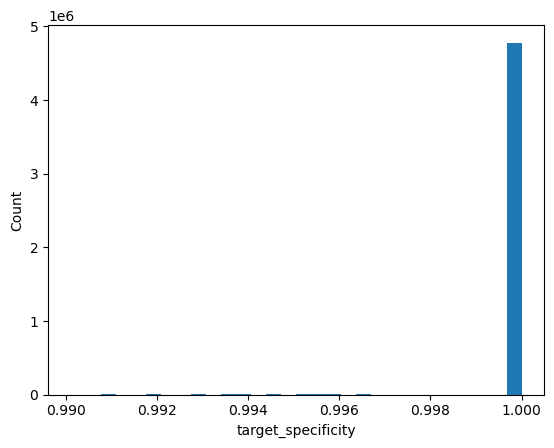

In [30]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## save probe_dict

In [31]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/2023_9_3_full_probe_isoforms.pkl


## Restart here

In [32]:
import pickle
full_probe_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/2023_9_3_full_probe_isoforms.pkl'
probe_dict = pickle.load(open(full_probe_filename, 'rb'))

## Select probe isoform

In [33]:
## Select transcript based on length / number of possible probes:
largest_probe_th = 1000
median_probe_th = 500


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trbc1
Trac
Iglc2
Tnfrsf13c
A530064D06Rik
Epcam
Cenpw
Irx2
Ifng
Clec4a3
Clec4b1
Clec4d
Nkg7
Sh2d1a
H2-DMb2
Ccnb1
Esco2
Rrm2
H2-Ab1
Smim5
H2-Eb1
Minpp1
Cyp2a12
Klk1
Klhdc1
Basp1
Vegfc
Mettl1
Rbp4
Cyp3a25
Cyp2c29
Cyp2c70
Nkain4
Sh3bgr
Krt14
BC028528
Ly6g
Akr1c6
Spc25
Akr1c20
Pglyrp1
Ndufa4l2
Cysltr2
Serpina1a
Fgf13
Hsd17b6
Serpina3m
Ms4a4c
Ms4a4b
Ms4a6c
Ms4a6d
Ms4a2
Gzma
Mcrs1
Hmgn2
Boll
Alox5ap
Klre1
Anxa1
Klrd1
Prok2
Ramp2
Klrc2
Klrc1
Klra17
Mt2
Mt1
Klra7
Klra3
Mzb1
Fpr2
Apoc4
Gstp2
Rras
Apoe
Sugct
Fam162a
Cstdc4
Cstdc5
Ctla2a
Dld
Batf3
Cpa3
Lect2
Polr2g
Hilpda
Gm21762
Cdca7
Rpl7l1
Nlrp4e
Bmi1
Sult1d1
Apoc3
Il4
Ctla4
Mcpt8
Aurkb
Gstm1
Calca
Pdhb
Pclaf
Kifc1
Vpreb3
Ceacam10
Arhgdig
Lgals1
Cd209a
Gpx3
Rhbdl2
Cd209d
S100a4
S100a6
Csf3r
Gm5150
Cxcl5
Pf4
Cxcl2
Bok
Tgs1
Sfrp2
Mcub
Cldn7
Il6
Sf3a2
Apoa2
Gemin6
Sds
F3
Aif1
Cd48
Arg1
Klrb1a
Prtn3
Cfh
Mrpl51
Cd27
Fcer1a
Wfdc2
Ifi205
Eno3
Mrgpra2b
Mrpl41
Ccl24
Il1b
Fcmr
Plk1
Lgalsl
Rnf149
Ccl5
Ccl9
Ccl6
Mrpl55
Phlda2
Tnfrsf23
Tnfsf12
Bnip3
Ltc4s
I

In [34]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[158] [158]
ENSMUST00000103679.3 158
[70] [70]
ENSMUST00000103563.3 70
[148, 104] [94, 94]
ENSMUST00000192856.6 148
[154] [154]
ENSMUST00000103299.3 154
[2002] [2002]
ENSMUST00000196323.2 2002
[507, 234] [234, 234]
ENSMUST00000198398.5 507
[36] [36]
ENSMUST00000103558.3 36
[41] [41]
ENSMUST00000103561.3 41
[330] [330]
ENSMUST00000103410.3 330
[916, 470] [406, 406]
ENSMUST00000194162.6 916
[1115, 1027] [915, 915]
ENSMUST00000177715.8 1115
[238] [238]
ENSMUST00000200568.2 238
[99] [99]
ENSMUST00000200235.2 99
[99, 153] [99, 99]
ENSMUST00000103749.3 153
[1339, 1244, 779, 1506, 1243] [1299, 1243, 732, 547, 1180]
ENSMUST00000237355.2 1339
[265, 2400, 1208, 1324, 1298, 358, 330, 379, 246] [26, 1311, 1189, 1324, 1279, 178, 316, 345, 241]
ENSMUST00000066208.13 1324
[616] [616]
ENSMUST00000075312.5 616
[1750] [1750]
ENSMUST00000070080.6 1750
[1997, 1829] [1829, 1829]
ENSMUST00000122333.2 1997
[1009, 1839, 1510] [405, 1512, 1510]
ENSMUST00000238155.2 1839
[1922, 92, 304, 197, 230, 396] [702, 77,

[2228, 218, 598, 583, 720, 1077, 34, 2390] [2204, 172, 185, 579, 700, 1023, 23, 2193]
ENSMUST00000100069.9 2228
[1484, 1311, 3229, 377, 432, 539, 303, 510] [623, 840, 941, 292, 117, 539, 263, 307]
ENSMUST00000067918.12 3229
[7584, 4079, 202, 2844, 1958, 1031, 947, 1062, 6610] [6629, 3983, 129, 658, 1280, 1031, 314, 29, 6593]
ENSMUST00000187541.7 7584
[3770, 4002, 3855, 432, 459, 608, 194, 126, 492, 559, 361, 259, 230] [3770, 3754, 3852, 295, 260, 575, 104, 96, 471, 527, 344, 259, 209]
ENSMUST00000208232.2 3855
[1284, 1654, 1786, 457, 571] [960, 1191, 1135, 408, 571]
ENSMUST00000149489.8 1654
[779] [779]
ENSMUST00000038886.3 779
[210, 513, 1611, 409, 493] [17, 500, 1030, 353, 464]
ENSMUST00000047311.16 1611
[145, 942, 60, 641] [12, 474, 41, 474]
ENSMUST00000063445.13 942
[2046, 1135, 1215, 695, 432, 358] [1281, 1135, 1082, 695, 416, 350]
ENSMUST00000143660.8 2046
[2374, 957, 415, 590, 557, 584] [1046, 936, 394, 572, 536, 377]
ENSMUST00000005255.9 2374
[1309, 241, 416, 201, 150, 680] [56

[1311, 2821, 114, 774, 1010] [1057, 1168, 114, 621, 362]
ENSMUST00000029297.6 2821
[1318, 1071, 451, 469] [1316, 1048, 298, 422]
ENSMUST00000020118.5 1318
[659, 551, 310] [436, 246, 295]
ENSMUST00000000058.7 659
[1948, 339, 1529, 2903, 2973, 1268, 1234, 381, 590] [1494, 314, 1408, 2903, 2886, 1251, 1226, 315, 123]
ENSMUST00000113161.10 2903
[2952, 3011, 280, 492, 482, 406, 2952] [2952, 3011, 265, 469, 333, 240, 2952]
ENSMUST00000101126.3 3011
[1892, 2029] [783, 818]
ENSMUST00000110549.3 2029
[253, 379, 480, 643] [162, 354, 465, 189]
ENSMUST00000206481.2 643
[813, 522, 6, 733, 641, 130, 837, 723, 650, 629, 787] [710, 69, 4, 641, 641, 0, 773, 706, 650, 277, 787]
ENSMUST00000231743.2 837
[3090, 364, 2490, 1765, 345, 222, 2289] [2560, 355, 2475, 1576, 288, 221, 2289]
ENSMUST00000115443.8 3090
[1637, 1513, 1433, 221] [1302, 1158, 1302, 164]
ENSMUST00000021617.14 1637
[642, 596, 827, 460, 296] [370, 392, 521, 439, 266]
ENSMUST00000034409.14 827
[4254, 4254] [4254, 4254]
ENSMUST00000032571.10

ENSMUST00000164192.9 2144
[1133] [1133]
ENSMUST00000051809.10 1133
[756, 962, 2169, 2186, 2199, 2135, 3739, 3816, 1029, 257, 917, 1670, 411, 1517, 1566, 412, 1302, 249, 1301, 2323] [385, 962, 2163, 2186, 2199, 2135, 3739, 3816, 1029, 45, 48, 1577, 411, 1517, 1566, 150, 1302, 230, 945, 2323]
ENSMUST00000239078.2 3816
[285, 127, 27, 543, 64, 90] [64, 127, 27, 39, 64, 90]
ENSMUST00000149494.2 543
[258, 162, 168, 256] [256, 141, 168, 256]
ENSMUST00000032270.13 258
[936] [936]
ENSMUST00000050385.6 936
[367, 346] [339, 339]
ENSMUST00000014687.11 367
[199, 132] [65, 65]
ENSMUST00000034214.8 199
[324, 351, 690] [233, 351, 321]
ENSMUST00000211807.2 690
[192, 621, 645, 676] [186, 603, 603, 600]
ENSMUST00000047568.5 676
[151] [151]
ENSMUST00000119096.2 151
[1755, 322, 172, 193] [498, 277, 148, 73]
ENSMUST00000039990.6 1755
[117, 101, 130, 119] [115, 101, 110, 119]
ENSMUST00000032286.7 130
[2161, 2138, 1484, 458, 286, 660, 572, 778, 266, 255, 293] [2102, 2017, 1484, 458, 268, 660, 572, 598, 225, 1

ENSMUST00000102798.8 2528
[247, 606, 362, 186, 434] [226, 587, 355, 185, 323]
ENSMUST00000193771.6 606
[831, 513, 572, 488, 309, 273, 520, 268] [682, 486, 495, 443, 294, 271, 266, 86]
ENSMUST00000087026.13 831
[2231] [2231]
ENSMUST00000045747.5 2231
[2026, 1959, 903, 666, 1278] [1998, 1958, 755, 585, 497]
ENSMUST00000037491.11 2026
[1551, 729, 59, 182, 235, 150, 856] [1512, 729, 21, 177, 145, 150, 807]
ENSMUST00000023486.15 1551
[637, 113] [66, 66]
ENSMUST00000001921.3 637
[1997, 1637, 862, 760, 875, 1866, 273, 600] [1639, 1629, 862, 721, 769, 61, 245, 185]
ENSMUST00000020165.14 1997
[373] [373]
ENSMUST00000033049.9 373
[2141, 1820] [1684, 1684]
ENSMUST00000169652.3 2141
[731, 924] [707, 707]
ENSMUST00000021970.11 924
[1503, 271, 230, 241, 110, 134] [516, 271, 211, 110, 83, 31]
ENSMUST00000022378.9 1503
[406, 403] [351, 351]
ENSMUST00000062806.6 406
[648, 699] [621, 621]
ENSMUST00000126417.3 699
[2312, 1614, 428, 1659, 1804, 1493, 1171, 381, 1359, 467, 336, 282, 1977] [1977, 1596, 428,

ENSMUST00000000924.13 1417
[657] [657]
ENSMUST00000222087.4 657
[460, 396] [317, 317]
ENSMUST00000121151.2 460
[1477, 571, 613, 430, 497, 249, 395, 984] [1477, 530, 533, 416, 480, 165, 211, 932]
ENSMUST00000170295.8 1477
[1252, 1199, 155, 24, 1593, 277, 236, 151, 833, 74] [1191, 1191, 133, 14, 309, 202, 216, 133, 75, 60]
ENSMUST00000069600.13 1252
[920, 985, 765, 570, 839, 636, 376, 1147, 995] [905, 667, 511, 570, 834, 463, 168, 1147, 995]
ENSMUST00000187313.7 1147
[1803, 422] [377, 331]
ENSMUST00000063956.7 1803
[377, 267, 341, 259] [315, 266, 316, 82]
ENSMUST00000038069.9 377
[892, 460, 1347] [892, 402, 740]
ENSMUST00000230743.2 892
[1872, 340, 295, 3318, 980, 977] [1786, 329, 194, 1785, 980, 977]
ENSMUST00000148442.8 1872
[1488, 240, 482, 970] [1173, 120, 203, 860]
ENSMUST00000027291.7 1488
[1170, 254, 1111] [1082, 243, 1077]
ENSMUST00000000208.13 1170
[2354, 307, 353, 553] [811, 250, 76, 485]
ENSMUST00000006614.3 2354
[422, 962, 1658, 1556, 388, 1582, 226, 504] [223, 640, 1658, 153

ENSMUST00000106899.4 1226
[2530, 428, 282, 407, 1631, 675, 1058] [2277, 268, 282, 205, 1625, 324, 1039]
ENSMUST00000052915.14 2530
[4472, 983, 1033, 1028, 941, 879, 642, 704, 553, 617, 657, 742, 693, 365, 513, 604, 294, 265, 246, 159] [1095, 971, 1033, 1028, 928, 866, 642, 704, 553, 616, 657, 739, 693, 349, 417, 468, 294, 251, 239, 152]
ENSMUST00000014174.14 4472
[2443, 468, 558, 361, 1082, 615, 405] [1066, 273, 548, 345, 856, 257, 388]
ENSMUST00000031411.15 2443
[1304] [1304]
ENSMUST00000006952.9 1304
[1796, 482, 1513, 430, 285, 352] [1662, 470, 1499, 394, 208, 128]
ENSMUST00000020779.11 1796
[1570, 352, 291, 217] [406, 337, 280, 200]
ENSMUST00000058352.15 1570
[1407, 823, 444, 500, 372, 1222] [1151, 748, 428, 325, 367, 1222]
ENSMUST00000163504.8 1222
[1160, 471] [436, 436]
ENSMUST00000017153.4 1160
[1712, 4586, 346, 477, 582] [1610, 2375, 346, 387, 417]
ENSMUST00000103220.4 4586
[2498, 2576, 2546, 2627, 2461, 2357, 2386, 1469, 392, 299, 346, 269, 299, 272, 257, 248] [2354, 2544, 2546

In [35]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdv4
	ENSMUST00000103679.3	158
Trgv2
	ENSMUST00000103563.3	70
Trbc1
	ENSMUST00000192856.6	148
Trbc2
	ENSMUST00000103299.3	154
Trdc
	ENSMUST00000196323.2	2002
Trac
	ENSMUST00000198398.5	507
Trgc1
	ENSMUST00000103558.3	36
Trgc2
	ENSMUST00000103561.3	41
Igkc
	ENSMUST00000103410.3	330
Ighd
	ENSMUST00000194162.6	916
Ighm
	ENSMUST00000177715.8	1115
Iglc1
	ENSMUST00000200568.2	238
Iglc3
	ENSMUST00000200235.2	99
Iglc2
	ENSMUST00000103749.3	153
Gramd3
	ENSMUST00000237355.2	1339
Aldh7a1
	ENSMUST00000066208.13	1324
Ttr
	ENSMUST00000075312.5	616
B4galt6
	ENSMUST00000070080.6	1750
Klhl14
	ENSMUST00000122333.2	1997
Chsy3
	ENSMUST00000238155.2	1839
Fstl1
	ENSMUST00000114763.3	1922
Apba1
	ENSMUST00000025830.9	3414
Cd74
	ENSMUST00000097563.9	940
Tmem252
	ENSMUST00000057243.6	2201
Lsamp
	ENSMUST00000187695.7	1918
Tfap2a
	ENSMUST00000110193.9	1249
Pdgfrb
	ENSMUST00000025522.11	3682
Gcnt2
	ENSMUST00000067778.8	2122
Egln3
	ENSMUST00000039516.4	1254
Cd248
	ENSMUST00000070630.8	1506

In [36]:
sequencing_data_folder = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X'
manual_kept_genes = pd.read_csv(os.path.join(sequencing_data_folder, 'merfish_4T1_genes_removed.csv'))

0        Ly6g
1     Alox5ap
2        Arg1
3       Cd79a
4        Cd3e
5       Cd8b1
6       Klrk1
7        Ncr1
8        Gzma
9        Gzmb
10      Batf3
11       Cpa3
12      Ms4a2
13     Fcer1a
14       Cd3g
15     Retnlg
16        Ngp
17       Fcnb
18       Ccl3
19      Cxcl3
20       Ifng
21        Il4
22      Wfdc2
Name: gene, dtype: object

In [43]:
kept_gene_list = []
removed_gene_list = []
for _gene, _t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if len(_pbs) < 800 and _gene not in list(manual_kept_genes['gene']):
        print(_gene)
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

Trdv4
Trgv2
Trbc1
Trbc2
Trac
Trgc1
Trgc2
Igkc
Iglc1
Iglc3
Iglc2
Ttr
Sntb1
Tnfrsf13c
Lyz2
Lyz1
Klrg1
9830107B12Rik
A530064D06Rik
Kcnk12
H3c3
H2ac4
Mfap5
Rrs1
Hhip
Cd200r3
Cenpw
Clec4a1
Clec4a3
Clec4b1
Fabp1
Lat
Clec4d
1700113H08Rik
Nkg7
H2-DMb2
Ccnb1
Lrg1
Sult2a1
Esco2
Rrm2
H2-Ab1
Smim5
Mbl2
H2-Aa
H2-Eb1
Spp1
Minpp1
Cyp2a12
Klk1b27
Klk1
Acsbg1
Csf3
Basp1
Serpinb9
Rbp4
Fgf2
Cyp3a25
Cyp2c29
Cyp2c39
Cyp2c70
Nkain4
Twist1
Sh3bgr
Ly6d
Krt14
Krt17
BC028528
Akr1c6
Spc25
Akr1c20
Gpihbp1
Diablo
Tmem37
Rtn1
Cav2
Pglyrp1
Ndufa4l2
Cysltr2
Serpina1a
Serpina1c
Hsd17b6
Nr2c2ap
Serpina3m
Ms4a4a
Ms4a4c
Ms4a4b
Ms4a6c
Ms4a6d
Ms4a3
Il17a
2510009E07Rik
Mcrs1
Gzmk
Birc5
Tmem47
Hmgn2
Boll
Tent5c
Il23a
Dusp10
Klre1
Tnfsf11
Rab25
Klrd1
Prok2
Ces1b
Ramp2
Snn
Klrc2
Klrc1
Klra17
Mt2
Mt1
Havcr1
Klra4
Klra7
Klra3
Bhmt
Krt8
Krt18
Igfbp6
Mzb1
Fpr1
Fpr2
Pira12
Otc
Aldh3b1
Apoc4
Gstp2
Rras
Sugct
Fam162a
Stfa2l1
Cstdc4
Cstdc6
Cstdc5
Stfa2
Stfa3
Ctla2a
Nme6
Camp
Vegfb
C1qb
C1qc
C1qa
Cox6a2
Lect2
H1f5
H2ac10
Cyp2j5
Polr2g


In [46]:
len(kept_gene_list)

746

In [47]:
target_gene_mean_exp_df.loc[np.array(kept_gene_list)]


,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,Neutrophil_mN1_liver,Tcell_CD4_memory,NKT_cells,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Trdc,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,0.000432,0.022925,0.144608,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,0.002842,0.002391,0.003484,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Ighm,0.205147,0.116890,3.079702,0.086627,0.224392,0.322190,0.012634,0.312088,0.330044,0.654622,...,0.005535,0.296212,0.113855,0.827244,0.018162,0.648157,2.036214,0.000000,0.277366,0.148772
Gramd3,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,0.007093,2.386506,1.935409,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Aldh7a1,0.002138,0.002872,0.125186,0.018453,0.011303,0.004022,0.002449,0.004158,0.035107,0.047300,...,0.128507,0.056699,0.039886,0.010037,0.413623,0.393636,0.023820,0.315688,0.026171,0.015686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D430036J16Rik,0.000000,0.000284,0.000918,0.000802,0.000120,0.000697,0.000000,0.001814,0.000000,0.001742,...,0.000717,0.000000,0.000000,0.004164,0.000000,0.000000,0.000000,0.003715,0.000000,0.189079
1700047M11Rik,0.024250,0.177883,0.013694,0.016808,0.126880,0.013320,0.019411,0.356058,0.000802,0.004536,...,0.000659,0.134595,0.000000,0.014943,0.015308,0.024795,0.022166,0.000000,0.000000,0.000000
4933440M02Rik,0.003742,0.000702,0.002096,0.000923,0.001680,0.001303,0.000000,0.002578,0.005398,0.001837,...,0.000000,0.000000,0.008192,0.006762,0.000000,0.000000,0.010416,0.000000,0.000000,0.000000


In [48]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [49]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

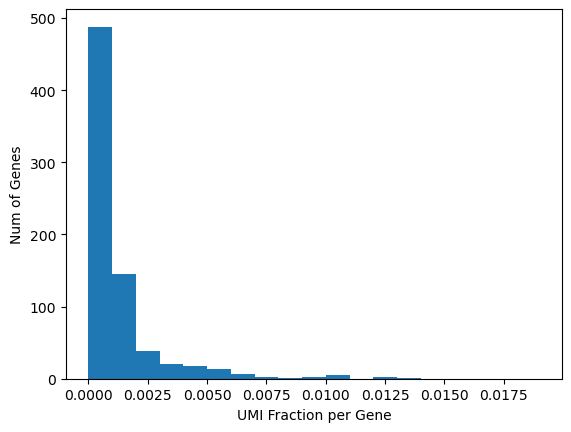

In [50]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

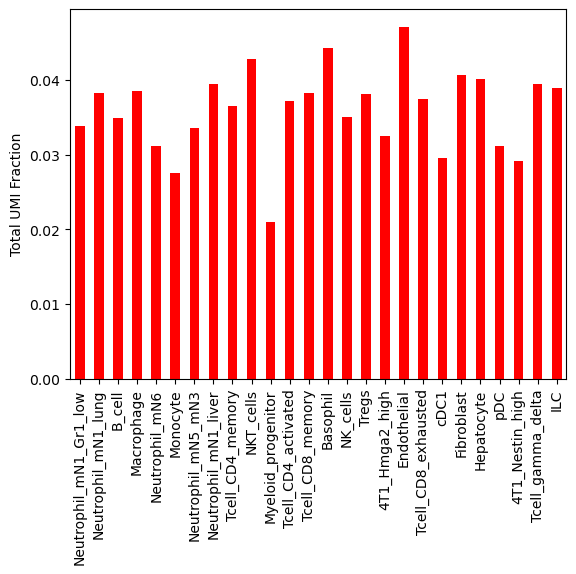

In [51]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [52]:
len(kept_gene_list)

746

## determine marker gene group

In [53]:
group_2_genes = {_g:[] for _g in target_gene_mean_exp_df.columns}
for _gene in kept_gene_list:
    _exp = target_gene_mean_exp_df.loc[_gene]
    _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

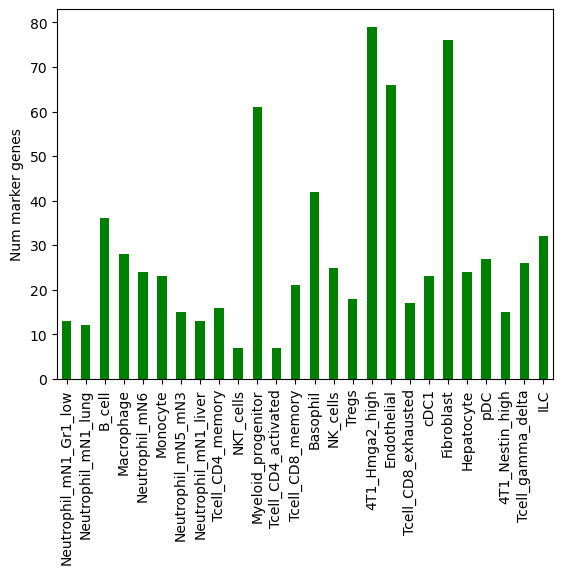

In [54]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

In [55]:
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

In [56]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(sel_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/2023_9_3_candidate_probe.pkl


In [140]:
# load probe_dict
probe_dict = pickle.load(open(full_probe_filename, 'rb'))

In [111]:
# delete
del(probe_dict)

In [62]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)
print(kept_gene_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF2_4T1Primary/kept_gene_info.csv


In [58]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Trdc,ENSMUST00000196323.2,2002,Tcell_gamma_delta,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,ENSMUST00000194162.6,916,B_cell,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Ighm,ENSMUST00000177715.8,1115,B_cell,0.205147,0.116890,3.079702,0.086627,0.224392,0.322190,0.012634,...,0.005535,0.296212,0.113855,0.827244,0.018162,0.648157,2.036214,0.000000,0.277366,0.148772
Gramd3,ENSMUST00000237355.2,1339,Tcell_CD8_memory,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Aldh7a1,ENSMUST00000066208.13,1324,Fibroblast,0.002138,0.002872,0.125186,0.018453,0.011303,0.004022,0.002449,...,0.128507,0.056699,0.039886,0.010037,0.413623,0.393636,0.023820,0.315688,0.026171,0.015686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D430036J16Rik,ENSMUST00000181893.9,998,Basophil,0.000000,0.000284,0.000918,0.000802,0.000120,0.000697,0.000000,...,0.000717,0.000000,0.000000,0.004164,0.000000,0.000000,0.000000,0.003715,0.000000,0.189079
1700047M11Rik,ENSMUST00000189594.2,1117,Neutrophil_mN1_liver,0.024250,0.177883,0.013694,0.016808,0.126880,0.013320,0.019411,...,0.000659,0.134595,0.000000,0.014943,0.015308,0.024795,0.022166,0.000000,0.000000,0.000000
4933440M02Rik,ENSMUST00000061823.3,2059,Myeloid_progenitor,0.003742,0.000702,0.002096,0.000923,0.001680,0.001303,0.000000,...,0.000000,0.000000,0.008192,0.006762,0.000000,0.000000,0.010416,0.000000,0.000000,0.000000
Wt1os,ENSMUST00000172701.8,1518,Fibroblast,0.000258,0.000302,0.000000,0.000760,0.000198,0.000844,0.000694,...,0.000000,0.000000,0.000000,0.000000,0.538093,0.000000,0.000000,0.016041,0.000000,0.000000


In [60]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

# PAUSE HERE, go to jupyter-3 to design codebook